In [ ]:
# Classification
# Code by Pascal Wallisch and Stephen Spivack
# Date: 12-06-21

In [ ]:
# In this lab - part 2 - we will build on the dataset from last time, when
# we did clustering.

# Today, we will use classification methods to predict which students will
# become depressed during college.

# First, we will need to use PCA to reduce the dimensionality of our data.
# Then, we will build two models - support vector machines and random
# forest classifiers - to actually *make* the predictions.

In [1]:
# 0. Init
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# 1. Loader
students = pd.read_csv('studentHealthData.csv')

In [3]:
# 2. Formatter
yOutcomes = students.depression.to_numpy()
predictors = students[["friends","fbfriends","extraversion", "neuroticism","stress","cortisol"]].to_numpy()

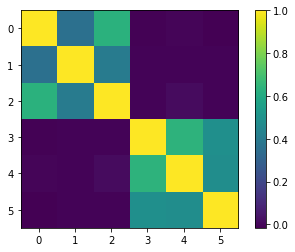

In [4]:
# 3. Visualize correlation matrix
r = np.corrcoef(predictors,rowvar=False)
plt.imshow(r) 
plt.colorbar()
plt.show()

In [5]:
# 4. Run the PCA

# Z-score the data:
zscoredData = stats.zscore(predictors)

# Initialize PCA object and fit to our data:
pca = PCA().fit(zscoredData)

# Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# Loadings (eigenvectors): Weights per factor in terms of the original data.
loadings = pca.components_*-1

# Rotated Data - simply the transformed data:
origDataNewCoordinates = pca.fit_transform(zscoredData)*-1

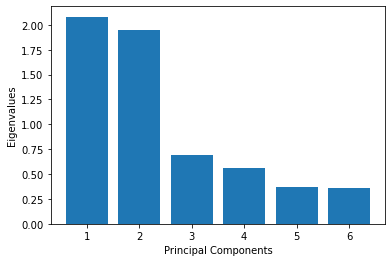

Proportion variance explained by the first 2 PCs: 0.671


In [6]:
# 5. Plot the eigenvalues
numPredictors = np.size(predictors,axis=1)
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()
print('Proportion variance explained by the first 2 PCs:',np.sum(eigVals[:2]/np.sum(eigVals)).round(3))

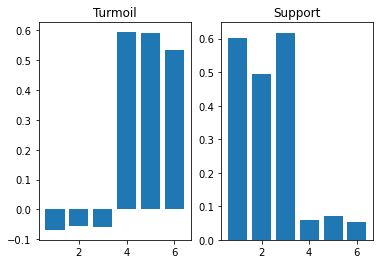

In [7]:
# 6. Plot the loadings and interpret the principal components
plt.subplot(1,2,1) 
plt.bar(np.linspace(1,numPredictors,numPredictors),loadings[0,:]) 
plt.title('Turmoil')
plt.subplot(1,2,2) 
plt.bar(np.linspace(1,numPredictors,numPredictors),loadings[1,:]) 
plt.title('Support')
plt.show()

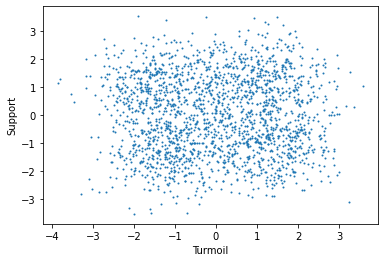

In [8]:
# 7. Visualize our data in the new coordinate system:
plt.plot(origDataNewCoordinates[:,0],origDataNewCoordinates[:,1],'o',markersize=1)
plt.xlabel('Turmoil')
plt.ylabel('Support')
plt.show()

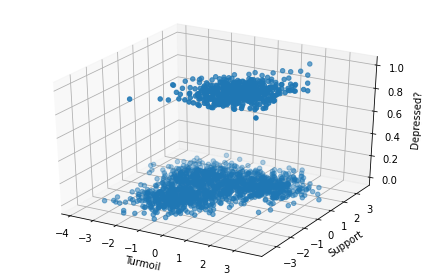

In [9]:
# 8. Classification: Using the predictors to predict an outcome

# Principle: in general, you use some data to build a model.
# Then you use other data to test the model and check how accurate it is

# A visual intuition:
X = np.transpose(np.array([origDataNewCoordinates[:,0],origDataNewCoordinates[:,1]]))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],yOutcomes)
ax.set_xlabel('Turmoil')
ax.set_ylabel('Support')
ax.set_zlabel('Depressed?') 
plt.tight_layout()
plt.show()
# This visualizes the issue: Some people do get depressed, others don't 

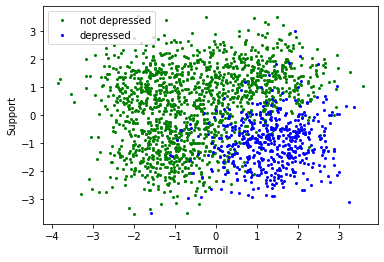

In [10]:
# Another view on this, but the outcome is represented by color, not a 3rd
# dimension. To make it clear that you have to draw a line in predictor
# space, not outcome space
plt.plot(X[np.argwhere(yOutcomes==0),0],X[np.argwhere(yOutcomes==0),1],'o',markersize=2,color='green')
plt.plot(X[np.argwhere(yOutcomes==1),0],X[np.argwhere(yOutcomes==1),1],'o',markersize=2,color='blue')
plt.xlabel('Turmoil')
plt.ylabel('Support')
plt.legend(['not depressed','depressed'])
plt.show()

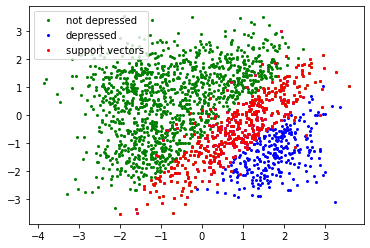

In [11]:
# 9. Support Vector Machines

# Name of the game: Draw a straight line ("linear separator") that optimally
# separates people with 1 outcome from people with another outcome. In
# higher dimensions: "Hyperplane", 2D: Line, 3D: Plane, 4D: Hyperplane

# Insight: 
# Given this data, it is impossible to draw a line that perfectly separates
# the subgroups (depressed vs. not). This is normal. There will be
# misclassifications (people who should be depressed, given how terrible
# everything is, but are not, and vice versa). 
# Does something have to be perfect to be good? The SVM finds what is called
# the "widest margin classifier" - that seperatates the two outcomes - in
# predictor space as best as possible. Widest possible margin that is
# spanned by the "support vectors". 

# Step 1: Fit the model to the data
clf = svm.SVC(kernel='linear').fit(X,yOutcomes)

# Step 2: Visualize the support vectors (you can skip this once you know
# what you're doing). For now, let's add that to the scatter plot.
sV = clf.support_vectors_ # Retrieve the support vectors from the model
plt.plot(X[np.argwhere(yOutcomes==0),0],X[np.argwhere(yOutcomes==0),1],'o',markersize=2,color='green')
plt.plot(X[np.argwhere(yOutcomes==1),0],X[np.argwhere(yOutcomes==1),1],'o',markersize=2,color='blue')
plt.plot(sV[:,0],sV[:,1],'o',markersize=2,color='red')
plt.legend(['not depressed','depressed','support vectors'])
plt.show()
# These "support vectors" span the decision boundary

In [12]:
# Step 3: Use model to make predictions and assess accuracy of model
# You will want to do this on new data to avoid overfitting. If you test the
# model on the same data that you fit it on, you will overestimate the
# accuracy of the model. It will not generalize because you are fitting to
# noise
predictions = clf.predict(X) # Decision reflects who the model thinks will be depressed

# Step 4: Assess model accuracy by comparing predictions with reality
modelAccuracy = accuracy_score(yOutcomes,predictions)
print('SVM model accuracy:',modelAccuracy)

# This model would predict the depression status of ~90% of the students
# correctly, given an overfit model. 

# SVM are a cardinal example of linear classifiers. They are used very
# often. Their advantage is that they are easily understood. Directly
# theoretically interpretable. Problem: They basically known to be too
# simple to really model complex phenomena perfectly.

# There is a large number of nonlinear classifiers, like CNNs, RNNs, ANNs,
# and so on. Here, we will show one commonly used one. The random forest.

SVM model accuracy: 0.899


In [13]:
# 10. The random forest

# Advantage: Very powerful. Allows to learn and model complex behavior of data. 
# Disadvantage: Very hard to interpret the output

# Build and fit model:
clf = RandomForestClassifier(n_estimators=100).fit(X,yOutcomes) # 100 trees

# Use model to make predictions:
predictions = clf.predict(X) 

# Assess model accuracy:
modelAccuracy = accuracy_score(yOutcomes,predictions)
print('Random forest model accuracy:',modelAccuracy)

Random forest model accuracy: 0.9995


In [ ]:
# We are able to predict ~100% of the outcomes with this model. There are 
# close to no errors. Even the strange cases, we got. The problem is that if 
# you have results that are too good to be true, they probably are not true. 
# We committed the sin of "overfitting", due to the fact that we used the
# same data to both fit ("train") the model and test it.

# The problem is that results from overfit models won't generalize because
# some proportion of the data is due to noise. If you fit perfectly, you fit
# to the noise. The noise will - by definition - not replicate. 

# Prescription: "Don't do that". Use one set of data to build the model and
# another to train it.

# Best solution: Get new data. Rarely practical.
# Most common solution: Split the dataset. There are many ways to do this,
# such as 80/20 (at random). The most powerful - but most computationally
# expensive - is to use leave-one-out: use the entire dataset to build the 
# model, expect for one point. Predict that point from n-1 data. Do that 
# many times - at random - and average the results. 

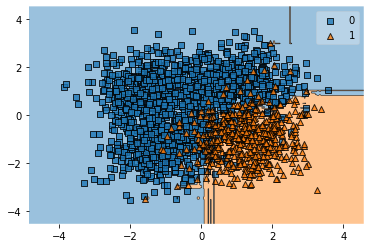

In [14]:
# Now let's plot the results from our random forest model:

# Note: you will first have to install the mlxtend library.
# For more info see: http://rasbt.github.io/mlxtend/

# %pip install mlxtend
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, yOutcomes, clf)
plt.show()